# Importando as biblitotecas necessárias

In [86]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as mpl
warnings.filterwarnings('ignore')

# Importando a base de dados

Usaremos a base de dados dos valores de ações da B3 de 1994 a 2020. Filtraremos sobre uma ação, ABEV3, para lidar com o teste de ADF.

In [87]:
df= pd.read_csv("b3_stocks_1994_2020.csv", parse_dates = ["datetime"])
abev3 = df[df["ticker"]=="ABEV3"].reset_index(drop=True).set_index("datetime")
abev3

,ticker,open,close,high,low,volume
datetime,,,,,,
2013-11-11,ABEV3,17.30,17.40,17.40,17.02,131358717.0
2013-11-12,ABEV3,17.30,17.06,17.37,16.76,197576325.0
2013-11-13,ABEV3,17.09,17.03,17.19,16.83,108370595.0
2013-11-14,ABEV3,17.25,17.47,17.50,17.05,244539146.0
2013-11-18,ABEV3,17.33,17.65,17.65,17.31,194172171.0
...,...,...,...,...,...,...
2020-12-22,ABEV3,15.50,15.51,15.75,15.47,240174447.0
2020-12-23,ABEV3,15.58,15.50,15.73,15.50,180470663.0
2020-12-28,ABEV3,15.57,15.77,15.94,15.50,188637870.0


# Criando as funções necessárias

- O objetivo da diferenciação fracionária é encontrar a fração d, que chamamos de ordem de diferenciação mínima: é o número mínimo necessário para atingir a estacionariedade, enquanto mantém a quantidade máxima de memória em nossos dados.
- O peso calculado é um recurso para dar importância aos valores mais recentes. O carimbo de data / hora atual pode ser expresso como a soma de todos os valores anteriores com um peso atribuído para cada valor. 
- Ao controlar o limite de peso, na verdade controlamos a duração da memória em vez da quantidade de memória (os primeiros alguns pontos têm mais peso, portanto, mais memória).

In [92]:
def getWeights_FFD(d, thres, lim=1):
    """
    Função serve para obter
    
    d: Fração da derivada
    k: Número de amostras
    w: Peso definido para cada amostra
    
    """
    
    w, k = [1.], 1
    ctr = 0
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
        ctr += 1
        if ctr == lim - 1:
            break
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def fracDiff_FFD(series,d,thres=1e-5):
    """
     Janela de largura constante (nova solução)
     
     Nota 1: thres determina o peso de corte para a janela
     Nota 2: d pode ser qualquer fracionário positivo, não necessariamente limitado [0,1].
    """
    
    #1) Pesos de cálculo para a série mais longa
    w=getWeights_FFD(d,thres)
    width=len(w)-1
    
    #2) Aplicar pesos aos valores
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1,name]):continue # exclude NAs
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df




Para calcular o coeficiente mínimo d, usaremos o teste Augmented Dickey-Fuller, que é um tipo de teste estatístico denominado teste de raiz unitária. A hipótese nula do teste é que a série temporal pode ser representada por uma raiz unitária, que não é estacionária (possui alguma estrutura dependente do tempo).


In [ ]:

def plotMinFFD(df, d_values = 20):
    """
    Fazemos a variação entre vários valores de d, dentro de um Range, e usamos isso para executar a função fracDiff_FFD.
    
    - No eixo y direito, ele plota a estatística ADF calculado sobre os preços. 
    - No eixo x, ele exibe o valor d usado para gerar a série na qual a estatística ADF foi calculada.
    
    A linha listrada mostra o ponto de 95% de nível de confiança.
    
    d_values: Quantos valores de d são analisados entre 0 e 1.
    """
    out=pd.DataFrame(columns =['adfStat','pVal','lags','nObs','95% conf','corr'])

    for d in np.linspace(0,1,d_values+1):
        df1=np.log(df[['close']]).resample('1D').last() # downcast to daily obs
        df2=fracDiff_FFD(df1,d,thres=.01)
        corr=np.corrcoef(df1.loc[df2.index,'close'],df2['close'])[0,1]
        df2=adfuller(df2['close'],maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
        
    out.columns =['adfStat','pVal','lags','nObs','95% conf','corr']
    out.to_csv('resultado_testMinFFD.csv')
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    mpl.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')

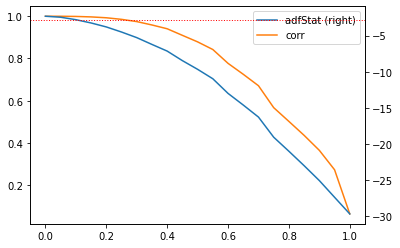

In [93]:
plotMinFFD(abev3)

In [100]:
results = pd.read_csv("resultado_testMinFFD.csv")
results.columns = ['d','adfStat','pVal','lags','nObs','95% conf','corr']

In [101]:
results

,d,adfStat,pVal,lags,nObs,95% conf,corr
0,0.00,-2.327970,1.631058e-01,1.0,1761.0,-2.863183,1.000000
1,0.05,-2.463552,1.245962e-01,1.0,1757.0,-2.863186,0.999886
2,0.10,-2.802568,5.790792e-02,1.0,1757.0,-2.863186,0.999073
3,0.15,-3.257504,1.688825e-02,1.0,1755.0,-2.863188,0.996883
4,0.20,-3.806018,2.846337e-03,1.0,1755.0,-2.863188,0.992767
5,0.25,-4.508982,1.894205e-04,1.0,1754.0,-2.863189,0.985292
6,0.30,-5.282461,5.952807e-06,1.0,1754.0,-2.863189,0.974694
7,0.35,-6.223869,5.144881e-08,1.0,1754.0,-2.863189,0.958631
8,0.40,-7.143514,3.277461e-10,1.0,1755.0,-2.863188,0.940709
9,0.45,-8.462992,1.549167e-13,1.0,1755.0,-2.863188,0.909507


# Pegando o primeiro valor com p-value inferior a 5%

O teste pode ser interpretado pelo  **p-value**. Um valor p abaixo de um limite 5% definido está sugerindo sugere que rejeitamos a hipótese nula (estacionário).

In [102]:
results.query("pVal < 0.05").head(1)

,d,adfStat,pVal,lags,nObs,95% conf,corr
3,0.15,-3.257504,0.016888,1.0,1755.0,-2.863188,0.996883
